# Preliminary Sizing
### EAE 130A

The following code outlines how we performed our preliminary sizing calculations. It is derived from the preliminary sizing tutorial.

In [52]:
import math
import numpy as np
import matplotlib.pyplot as plt

Intro & Equation explanation

0.013
0.0251334215945771


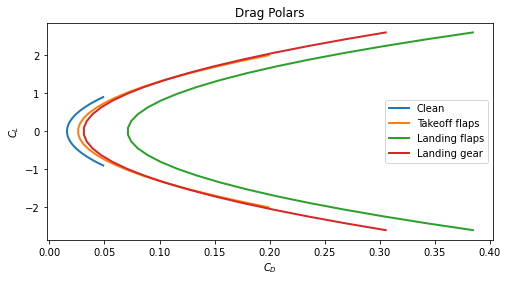

In [53]:
## Drag Polar Estimate
w_to = 57006    #lbs, takeoff weight
c_f = 0.0026    #skin friction coefficient, Raymer 12.3
c_l = 0.75       ##lift coefficient
"""
c = -0.0866     #Table 3.5 Roskam
d = 0.8099      #Table 3.5 Roskam
s_wet = (10**c)*(w_to**d)
print(s_wet)
rho = 0.0023769        #slug/ft3
c_lmax = 1.9
c_lcruise = 0.5
v_stall = 590.733*np.sqrt(c_lcruise/c_lmax)         #stall speed, ft/s
ws = 0.5*rho*(v_stall**2)*c_l #wingloading, Martins Eq 4.2  #lb/sqft
print(ws)   
s_ref = w_to/ws   #sq.ft, from tutorial
print(s_ref)  
""" 
s_ratio = 5     
c_do = c_f*(s_ratio)
print(c_do)
e_v = 0.80 ## span efficiency factor
ar = 18.44588 ## aspect ratio
c_d = c_do + ((c_l**2)/((np.pi)*e_v*ar))
print(c_d)

# Adjust C_Lmax for each flight configuration
cL_clean = np.linspace(-0.9,0.9,30)
cL_takeoff = np.linspace(-2,2,30)
cL_landing = np.linspace(-2.6,2.6,30)
clean = 0.01597 + 0.0406*(cL_clean**2)
takeoff = 0.02597 + 0.0433*(cL_takeoff**2)
landing_flaps = 0.07097 + 0.0464*(cL_landing**2)
landing_gear = 0.03097 + 0.0406*(cL_landing**2)

plt.figure(figsize=(8,4))
plt.title('Drag Polars')
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.plot(clean, cL_clean, label='Clean', linestyle='-', linewidth=2)
plt.plot(takeoff, cL_takeoff, label='Takeoff flaps', linestyle='-', linewidth=2)
plt.plot(landing_flaps, cL_landing, label='Landing flaps', linestyle='-', linewidth=2)
plt.plot(landing_gear, cL_landing, label='Landing gear', linestyle='-', linewidth=2)
plt.legend(loc='best')
plt.show()

In [54]:
## Takeoff Field Length
bfl = 12000
top = bfl/37.5
s_land = bfl * 0.6
s_a = 1000      #from tutorial
rho_tot = 0.95  #given during tutorial
tw = ws/((rho_tot)*c_lmax*top)
## Landing Field Length
ws_clmax = (rho_tot/(top*0.65))*(s_land - s_a)
